## Import Libraries

In [36]:
import os

os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [37]:
from PIL import Image
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd

import cv2
from imageio import imread
import matplotlib.pyplot as plt

from dotenv import load_dotenv

%matplotlib inline

## Utility functions

In [38]:
def save_webcam_image(img_path):
    camera = cv2.VideoCapture(0)  # Open webcam (0 = default webcam)
    
    if not camera.isOpened():
        print("❌ Webcam not found or not accessible.")
        return False  # Return False if webcam is not available

    retval, im_camera = camera.read()

    if not retval:  # Check if an image was captured successfully
        print("❌ Failed to capture image from webcam.")
        return False  

    im = cv2.resize(im_camera, (224, 224)).astype(np.float32)  # Resize image
    cv2.imwrite(img_path, im)  # Save image
    camera.release()  # Release the webcam
    return True  # Return True if image is saved successfully

In [ ]:
def predict_image(model, img_path, preprocess_input_fn, decode_predictions_fn, target_size=(224, 224)):

    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input_fn(x)
    
    preds = model.predict(x)
    predictions_df = pd.DataFrame(decode_predictions_fn(preds, top=5)[0])
    predictions_df.columns = ["Predicted Class", "Name", "Probability"]
    return predictions_df

In [ ]:
def display_image_prediction(model, img_path, preprocess_input, decode_predictions_fn):
    # Check if img_path not found
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image path not found: ".format(img_path))
    # Load the image for display
    img = Image.open(img_path)
    # Make predictions
    predictions = predict_image(model, img_path, preprocess_input, decode_predictions_fn)
    # Display the image and predictions
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    plt.imshow(img)
    plt.title(f"Predictions for {img_path}")
    plt.axis('off')  # Turn off axis ticks and labels

    # Display top 5 predictions as text on the plot
    prediction_text = "\n".join([f"{name}: {prob:.6f}" for _, name, prob in predictions.values[:5]])  # Show top 5 predictions
    plt.text(0.05, 0.05, prediction_text, transform=plt.gca().transAxes, fontsize=8, color='white',
                bbox=dict(facecolor='black', alpha=0.5))

    plt.show()

## Show Example Picture

C:\Users\cartoongummy\AppData\Local\Temp\ipykernel_18596\1324635844.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imread(img_path))


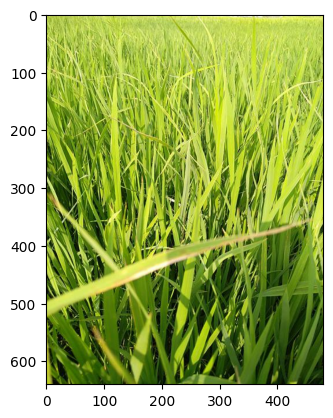

In [40]:
load_dotenv()
img_path = os.getenv('IMG_PATH')

plt.imshow(imread(img_path))

## Use Pretrained Model


In [41]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [42]:
resnet50_model = ResNet50(weights = 'imagenet')

In [43]:
resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [44]:
predict_image(resnet50_model, img_path, preprocess_input, decode_predictions)

1/1 [==============================] - 1s 1s/step


,Predicted Class,Name,Probability
0,n02231487,walking_stick,0.166899
1,n13133613,ear,0.062429
2,n03649909,lawn_mower,0.039439
3,n03991062,pot,0.034469
4,n07714571,head_cabbage,0.032855
5,n07716906,spaghetti_squash,0.031476
6,n12144580,corn,0.028103
7,n09256479,coral_reef,0.025919
8,n02906734,broom,0.025790
9,n04208210,shovel,0.021706


In [ ]:
display_image_prediction(resnet50_model, img_path, preprocess_input, decode_predictions)

## Train Model for new 10 Classes

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
'''
Bacterial_leaf_blight => โรคขอบใบแห้ง
Bacterial_leaf_streak => โรคขีดใบโปร่งแสง
Bacterial_panicle_blight => โรคกาบใบแห้ง
Blase => โรคไหม้
Brown_spot => โรคใบจุดสีน้ำตาล
Dead_heart => โรคยอดเหี่ยว
Downy_mildew => โรคราน้ำค้าง
Hispa => โรคแมลงกัดใบข้าว
Normal => ปกติ
Tungro => โรคใบสีส้ม
'''

num_classes = ['bacterial_leaf_blight' 'bacterial_leaf_streak'
 'bacterial_panicle_blight' 'blast' 'brown_spot' 'dead_heart'
 'downy_mildew' 'hispa' 'normal' 'tungro']

In [ ]:
# สร้าง Fully Connected Layer ใหม่
x = Flatten()(resnet50_model.output)  # แปลง Feature Maps เป็น Vector
x = Dense(512, activation='relu')(x)  # Fully Connected Layer
# x = Dropout(0.5)(x)  # comment ไว้ก่อน ตอนรันครั้งแรก ERROR
output = Dense(num_classes, activation='softmax')(x)  # Output Layer (10 Classes)

# สร้างโมเดลใหม่
new_model = Model(inputs=resnet50_model.input, outputs=output)


In [ ]:
'''Arguments

initial_learning_rate: A Python float. The initial learning rate.
decay_steps: How often to apply decay.
decay_rate: A Python number. The decay rate.
staircase: Whether to apply decay in a discrete staircase, as o pposed to continuous, fashion.
name: String. Optional name of the operation. Defaults to "InverseTimeDecay". 

'''

lr_scheduler = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_rate=1e-6, decay_steps=1, staircase = False)

opt = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# สร้าง ImageDataGenerator สำหรับเพิ่มข้อมูลผ่าน Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2,
    fill_mode = 'wrap', # เนื่องจากว่าเรามีการ shift ภาพ ดังนั้นเราจึงจะเติมส่วนที่หายไปจากการ shift ด้วย wrap 
    horizontal_flip=True, 
    validation_split=0.2  # แบ่ง Validation 20%
)

# โหลดข้อมูล Training และ Validation
train_generator = train_datagen.flow_from_directory(
    '../Data/train_images',  # เปลี่ยนเป็น path ของคุณ
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '../Data/train_images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.


In [49]:

print("Train data:", train_generator.samples)
print("Validation data:", val_generator.samples)


Train data: 8330
Validation data: 2077


In [ ]:
history = new_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # ปรับจำนวนรอบการ Train ตามต้องการ
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)


Epoch 1/10
261/261 [==============================] - 188s 689ms/step - loss: 2.1287 - accuracy: 0.2148 - val_loss: 2.2754 - val_accuracy: 0.1695
Epoch 2/10
261/261 [==============================] - 178s 681ms/step - loss: 2.0643 - accuracy: 0.2606 - val_loss: 2.6875 - val_accuracy: 0.1695
Epoch 3/10
261/261 [==============================] - 174s 668ms/step - loss: 1.8830 - accuracy: 0.3361 - val_loss: 2.5012 - val_accuracy: 0.1531
Epoch 4/10
261/261 [==============================] - 173s 664ms/step - loss: 1.7189 - accuracy: 0.4028 - val_loss: 2.2429 - val_accuracy: 0.1541
Epoch 5/10
261/261 [==============================] - 177s 680ms/step - loss: 1.6452 - accuracy: 0.4227 - val_loss: 2.2786 - val_accuracy: 0.1675
Epoch 6/10
261/261 [==============================] - 180s 688ms/step - loss: 1.6998 - accuracy: 0.4053 - val_loss: 1.8229 - val_accuracy: 0.3505
Epoch 7/10
261/261 [==============================] - 177s 677ms/step - loss: 1.5308 - accuracy: 0.4659 - val_loss: 1.9027 -

# Fine-Tuning

In [ ]:
# Unfreeze Layers ตั้งแต่ Block ที่ 3 เป็นต้นไป
for layer in resnet50_model.layers[-30:]:
    layer.trainable = True

lr_scheduler = tf.keras.optimizers.schedules.InverseTimeDecay(1e-5, decay_rate=1e-6, decay_steps=1, staircase = False)

opt = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

# Compile ใหม่ด้วย Learning Rate ที่ต่ำลง
new_model.compile(optimizer = opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Fine-Tuning โมเดล
history_fine_tune = new_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,  # เพิ่มรอบการ Train
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)


Epoch 1/5
261/261 [==============================] - 181s 673ms/step - loss: 1.2412 - accuracy: 0.5615 - val_loss: 1.2472 - val_accuracy: 0.5710
Epoch 2/5
261/261 [==============================] - 173s 663ms/step - loss: 1.2213 - accuracy: 0.5711 - val_loss: 1.2183 - val_accuracy: 0.5763
Epoch 3/5
261/261 [==============================] - 175s 670ms/step - loss: 1.1991 - accuracy: 0.5792 - val_loss: 1.1948 - val_accuracy: 0.5898
Epoch 4/5
261/261 [==============================] - 174s 667ms/step - loss: 1.1908 - accuracy: 0.5888 - val_loss: 1.1858 - val_accuracy: 0.5903
Epoch 5/5
261/261 [==============================] - 174s 668ms/step - loss: 1.1915 - accuracy: 0.5868 - val_loss: 1.1808 - val_accuracy: 0.5898


In [ ]:
new_model.save('resnet50_finetuned.h5')